In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('archive/chicago_taxi_trips_2016_11.csv') 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295000 entries, 0 to 1294999
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   taxi_id                 1294453 non-null  float64
 1   trip_start_timestamp    1295000 non-null  object 
 2   trip_end_timestamp      1294850 non-null  object 
 3   trip_seconds            1294564 non-null  float64
 4   trip_miles              1294987 non-null  float64
 5   pickup_census_tract     0 non-null        float64
 6   dropoff_census_tract    826575 non-null   float64
 7   pickup_community_area   1176867 non-null  float64
 8   dropoff_community_area  1149193 non-null  float64
 9   fare                    1294983 non-null  float64
 10  tips                    1294983 non-null  float64
 11  tolls                   1294983 non-null  float64
 12  extras                  1294983 non-null  float64
 13  trip_total              1294983 non-null  float64
 14  pa

In [3]:
## Adjacency Matrix (Directed Graph)
## pickup vs dropoff : number of trips (one way) 
df = pd.crosstab(data.pickup_community_area, data.dropoff_community_area)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0) 
df.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0
1.0,1151,436,300,80,24,179,62,183,1,4,...,0,0,1,0,0,0,0,0,109,512
2.0,333,2065,116,186,43,69,28,122,1,7,...,0,1,0,0,0,0,0,0,120,329
3.0,456,273,4581,579,288,2462,597,1631,4,16,...,0,1,0,1,0,0,0,0,349,1247
4.0,69,264,367,1047,173,266,120,206,5,4,...,0,0,0,0,0,0,0,0,166,291
5.0,39,46,199,230,661,682,218,386,2,12,...,1,0,0,0,0,0,0,0,273,82


In [4]:
# df.info() 

In [5]:
import networkx as nx
def draw(G):
    from pylab import rcParams
    rcParams['figure.figsize'] = 14, 10

    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos, node_size=2500, node_color ='green')
    labels = nx.get_edge_attributes(G, 'weight') 
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels) 

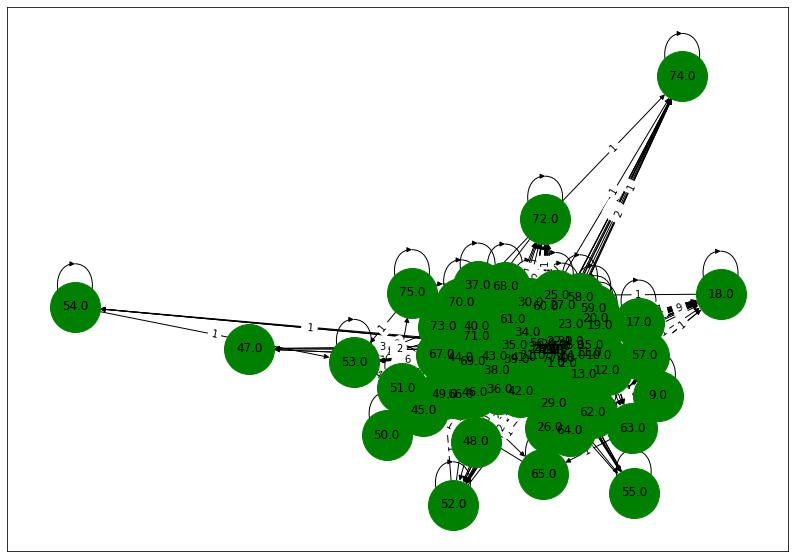

In [6]:
## Directed Graph 
G_di = nx.from_pandas_adjacency(df, create_using=nx.DiGraph) 

draw(G_di)

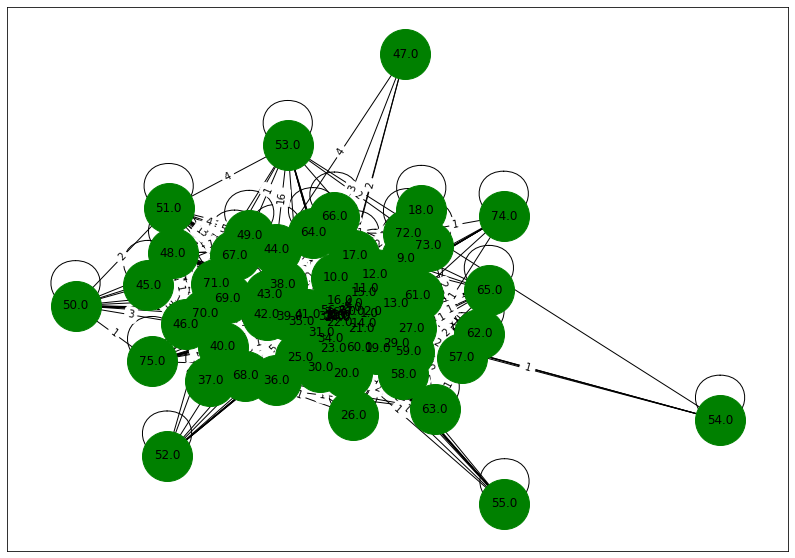

In [7]:
## Undirected Graph 
## pickup vs dropoff : number of trips (to and fro) 
G_un = nx.Graph()
G_un.add_edges_from(G_di.edges(), weight=0) 
for u, v, d in G_di.edges(data=True):
    G_un[u][v]['weight'] += d['weight']

draw(G_un)

In [8]:
A_di = nx.to_numpy_array(G_di) 
A_un = nx.to_numpy_array(G_un) 
# print(A_di) 
# print(A_un) 

In [9]:
"""
Spectral Clustering (Un-Normalized/Normalized)

A: Adjacency matrix 
k: n_clusters 

"""
def spectral_clustering(A, k=3, normalization=False): 
    D = np.diag(A.sum(axis=1)) 
    # L = D-A 
    from scipy.sparse import csgraph 
    L = csgraph.laplacian(A, normed=normalization)

    
    vals, vecs = np.linalg.eig(L) 
    vecs = vecs[:,np.argsort(vals)] 
    vals = vals[np.argsort(vals)] 
    
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vecs[:,1:k])
    clusters = kmeans.labels_
    print("Clusters:", clusters) 
    
    best_cut = vecs[:,1] > 0 
    
    return clusters, best_cut 

Clusters: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 1]


(array([75.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

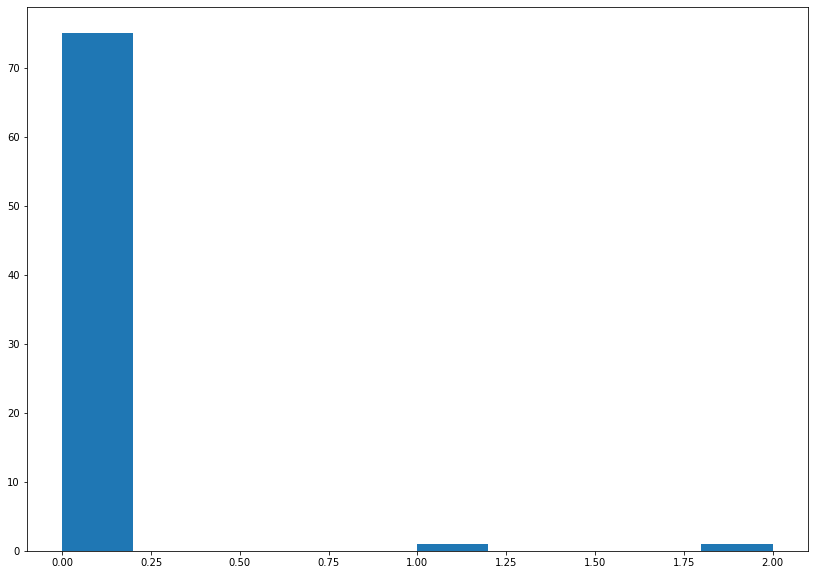

In [10]:
clusters, best_cut = spectral_clustering(A_un, k=3, normalization=False) 
plt.hist(clusters)

Clusters: [0 1 2 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 2 1 2 2 2 1 1 1 1 1 1 2 1 2 2 2 2 1 1 1 1 2
 1 1 1]


(array([12.,  0.,  0.,  0.,  0., 42.,  0.,  0.,  0., 23.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

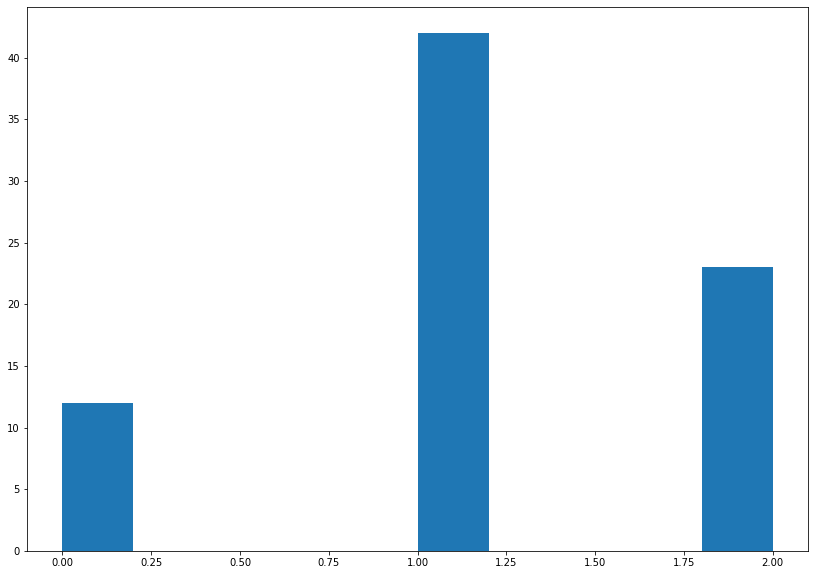

In [12]:
clusters, best_cut = spectral_clustering(A_un, k=3, normalization=True) 
plt.hist(clusters)